## Data Processing

Machine learning models make a lot of assumptions about the data. However, in reality, these assumptions are often violated. <p>

We build ***pipelines*** that *transform* the data before feeding it to the learners:

- Scaling (or other numeric transformations)

- Encoding (convert categorical features into numerical ones)

- Automatic feature selection

- Feature engineering (e.g. binning, polynomial features,…)

- Handling missing data

- Handling imbalanced data

- Dimensionality reduction (e.g. PCA)

- Learned embeddings (e.g. for text)

### 1. Scaling


**Goal**: bring all fearures within the same range <p>

Use when different numeric features have different scales (different range of values) <p>

**Why Scaling?**

- Features with much higher values may overpower the others

- Method based on distances (e.g. kNN, SVMs) will over-emphasize those features

- Parametric models (e.g. linear models, neural nets) become hard to train (sensitive weights)

In [1]:
# 使用 scikit-learn 库可视化不同 Scaling 方法对鸢尾花（Iris）数据集的影响

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler, Normalizer, MaxAbsScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Iris dataset with some added noise
def noisy_iris():
    iris = fetch_openml("iris", version=1, return_X_y=True, as_frame=False) # X:150*4的特征矩阵
    X, y = iris
    
    np.random.seed(0)
    noise = np.random.normal(0, 0.1, 150)
    for i in range(4):
        X[:, i] = X[:, i] + noise
    X[:, 0] = X[:, 0] + 3 # add more skew 
    
    # 类别标签转换为数字格式
    label_encoder = LabelEncoder().fit(y)
    y = label_encoder.transform(y)

    return X, y

scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), Normalizer(norm='l1'), MaxAbsScaler()]

# 绘制子图
def plt_sub(X,y,axes,sub_num,title):

    axes[sub_num].scatter(X[:, 0], X[:, 1],  c=y, s=20, cmap="brg")
    axes[sub_num].set_title(title)
    axes[sub_num].set_xlabel("Feature 1")
    axes[sub_num].set_ylabel("Feature 2")
    axes[sub_num].set_xlim(-15, 15)
    axes[sub_num].set_ylim(-5, 5)
    axes[sub_num].axhline(0, color='black', linewidth=0.5, ls='--')
    axes[sub_num].axvline(0, color='black', linewidth=0.5, ls='--')
    axes[sub_num].grid()


def plot(scaler=scalers[0]):
    
    X,y= noisy_iris()
    X_ = scaler.fit_transform(X)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
    plt_sub(X,y,axes,0,"original data")
    plt_sub(X_,y,axes,1, "data after scaled")
    plt.tight_layout()  # 自动调整子图间距
    plt.show()
    

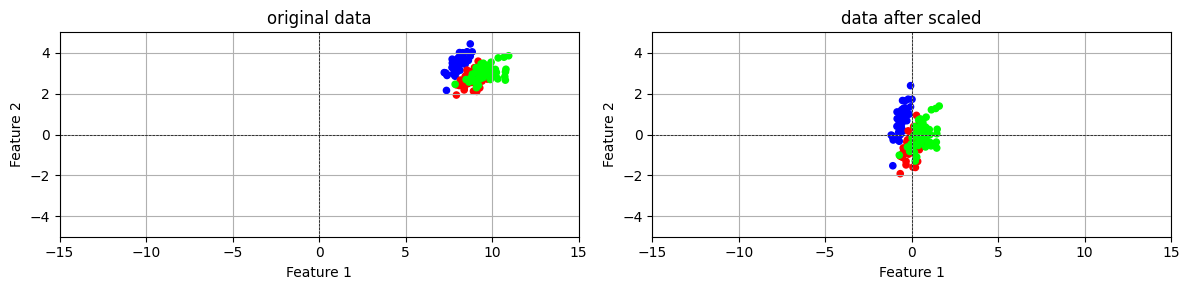

In [59]:
plot(scalers[1])

### 2. Power Transformation

高度偏斜的特征: 数据分布不均匀、不对称的特征
<p>

处理之后:使其分布更接近**正态分布**或至少减少偏斜程度 <p>

处理方法:

- Box-Cox transformation: 一种通用的 **幂变换( power transformation)** 方法

    - Only works for positive values, use Yeo-Johnson otherwise
    $$bc_{\lambda}(x) = \begin{cases} log(x) & \lambda = 0\\ \frac{x^{\lambda}-1}{\lambda} & \lambda \neq 0 \\ \end{cases}$$

- Yeo-Johnson变换: Box-Cox的扩展, 可以处理负值和零

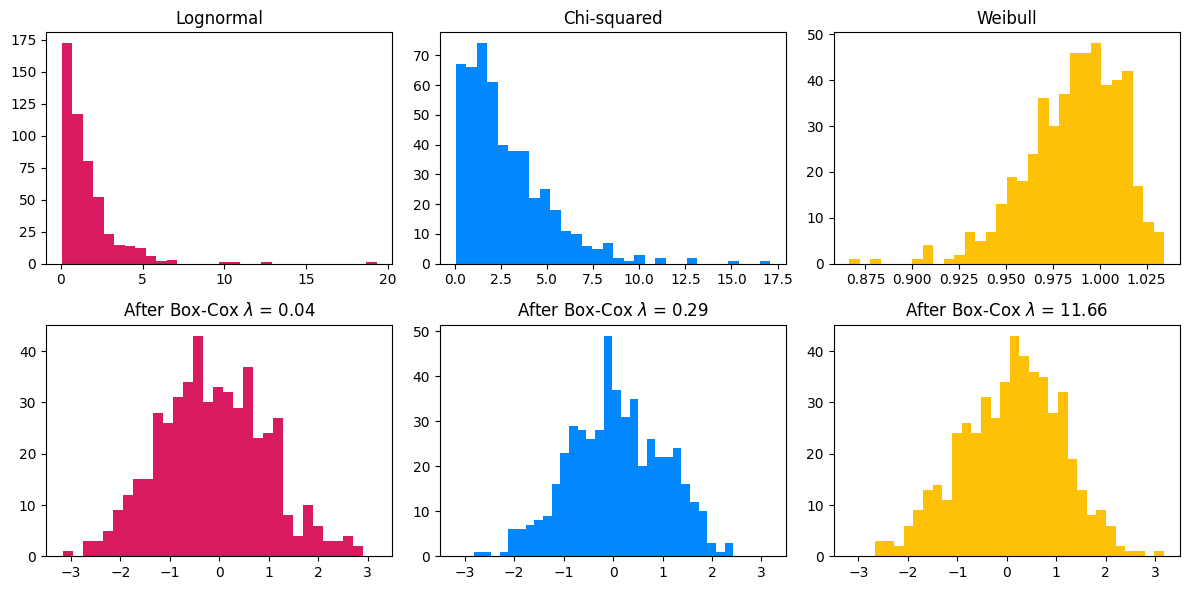

In [2]:
# Adapted from an example by Eric Chang and Nicolas Hug 
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

# Power transformer with Box-Cox
bc = PowerTransformer(method='box-cox')

# Generate data
rng = np.random.RandomState(304) # Random number generator
size = (1000, 1)
X_lognormal = rng.lognormal(size=size) # lognormal distribution
X_chisq = rng.chisquare(df=3, size=size) # chi-squared distribution
X_weibull = rng.weibull(a=50, size=size) # weibull distribution

# create plots
distributions = [
    ('Lognormal', X_lognormal),
    ('Chi-squared', X_chisq),
    ('Weibull', X_weibull)
]
colors = ['#D81B60', '#0188FF', '#FFC107']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
axes = axes.flatten()
axes_idxs = [(0, 3), (1, 4), (2, 5)]
axes_list = [(axes[i], axes[j]) for (i, j) in axes_idxs]

for distribution, color, axes in zip(distributions, colors, axes_list):
    name, X = distribution
    X_train, X_test = train_test_split(X, test_size=.5)

    # perform power transforms and quantile transform
    X_trans_bc = bc.fit(X_train).transform(X_test)
    lmbda_bc = round(bc.lambdas_[0], 2)

    ax_original, ax_bc = axes
    ax_original.hist(X_train, color=color, bins=30)
    ax_original.set_title(name)
    ax_original.tick_params(axis='both', which='major')

    ax_bc.hist(X_trans_bc, color=color, bins=30)
    title = 'After {}'.format('Box-Cox')
    if lmbda_bc is not None:
        title += r' $\lambda$ = {}'.format(lmbda_bc)
    ax_bc.set_title(title)
    ax_bc.tick_params(axis='both', which='major')
    ax_bc.set_xlim([-3.5, 3.5])


plt.tight_layout()
plt.show()

### 3. Categorical feature encoding
-  Many algorithms can only handle numeric features, so we need to encode the categorical ones

#### 3.1. Ordinal encoding
Simply assigns an **integer value** to each category in the order they are encountered. Only really useful if there exist a **natural order** in categories. Model will consider one category to be ‘higher’ or ‘closer’ to another

#### 3.2. One-hot encoding (dummy encoding)

Simply adds a new 0/1 feature for every category, having 1 (hot) if the sample has that category.(为每个类别创建一个二进制特征向量, 向量的长度等于类别的数量)

- Pros:
    - **解决分类数据处理问题**: 独热编码将离散分类特征转换为机器学习算法易于处理的二进制格式, 提高了算法对离散特征的处理能力.
    - **避免引入数值偏误**:通过将每个类别映射到独立的二进制向量, 独热编码消除了类别间可能存在的错误数值关系, 从而避免了算法基于这些关系做出不准确的预测.

- Cons
    - Can explode if a feature has lots of values, causing issues with high dimensionality
    - **信息损失风险**: 独热编码可能无法充分捕捉类别间的潜在关系或顺序信息, 从而在某些情况下导致有用信息的丢失

#### 3.3. Label encoding

#### 3.4. Target encoding 

特征编码可以仅基于特征本身进行, 也可以结合目标值(target)的信息进行. `Target Encoding` 的核心思想是用目标变量的平均值来替换分类变量的每个类别. 这种方法试图捕捉每个类别与目标变量之间的关系.


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

X = pd.DataFrame({'boro': ['Manhattan', 'Queens', 'Manhattan', 'Brooklyn', 'Brooklyn', 'Bronx'],
                   'salary': [103, 89, 142, 54, 63, 219]})
y = pd.DataFrame({'vegan': [0, 0, 0, 1, 1, 0]})
df = X.copy()
df['vegan'] = y

print(df)


# -------------------------- Ordinal encoding ----------------------------------
encoder = OrdinalEncoder(dtype=int)

# Encode first feature, rest passthrough
# 'cat' 是此转换器的名称
# [0] 指定了要应用此编码器的列索引(这里是第 0 列, 即类别特征"boro")
preprocessor = ColumnTransformer(transformers=[('cat', encoder, [0])], remainder='passthrough')
X_ordinal = preprocessor.fit_transform(X,y)

# Convert to pandas for nicer output
df = pd.DataFrame(data=X_ordinal, columns=["boro_ordinal","salary"])
df = pd.concat([X['boro'], df], axis=1)
df

# -------------------------- Onehot encoding ----------------------------------
encoder = OneHotEncoder(dtype=int)

# Encode first feature, rest passthrough
preprocessor = ColumnTransformer(transformers=[('cat', encoder, [0])], remainder='passthrough')
X_ordinal = preprocessor.fit_transform(X,y)

# Convert to pandas for nicer output
df = pd.DataFrame(data=X_ordinal, columns=["boro_Bronx","boro_Brooklyn","boro_Manhattan","boro_Queens","salary"])
df = pd.concat([X['boro'], df], axis=1)
df

        boro  salary  vegan
0  Manhattan     103      0
1     Queens      89      0
2  Manhattan     142      0
3   Brooklyn      54      1
4   Brooklyn      63      1
5      Bronx     219      0


,boro,boro_Bronx,boro_Brooklyn,boro_Manhattan,boro_Queens,salary
0,Manhattan,0,0,1,0,103
1,Queens,0,0,0,1,89
2,Manhattan,0,0,1,0,142
3,Brooklyn,0,1,0,0,54
4,Brooklyn,0,1,0,0,63
5,Bronx,1,0,0,0,219


### 4. Applying data transformations 的两个误区

* Data transformations should always follow a `fit-predict` paradigm
    * 'Fit' (train) the transformer on the **training data** only
        * E.g. for a standard scaler: record the mean and standard deviation
    * Transform (e.g. scale) the **training data**, then train the learning model
    * Transform (e.g. scale) the **test data**, then evaluate the model
* Only scale the input features (X), not the targets (y)!
* If you fit and transform the whole dataset before splitting, you get **data leakage**
    * You have looked at the test data before training the model
* If you fit and transform the training and test data separately, you **distort the test set**
    * E.g. training and test points are scaled differently
* In both cases, model evaluations will be misleading or meaningless


#### 4.1. Data Leakage

- Cross-validation: training set is split into training and validation sets for model selection
- Incorrect: Scaler is fit on whole training set before doing cross-validation
    - Data leaks from validation folds into training folds, selected model may be optimistic
- Right: Scaler is fit on training folds only

<img src="https://raw.githubusercontent.com/ML-course/master/master/notebooks/images/infoleak.png" alt="ml" style="width: 1500px;"/>

#### 4.2. Test set distortion
- **Properly scaled**: `fit` on training set, `transform` on training and test set
- **Improperly scaled**: `fit` and `transform` on the training and test data separately
    - Test data points nowhere near same training data points

### 5. Data processing pipelines

`pipeline`类本身具有`fit`, `predict`和`score`方法.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Make pipeline
pipe = make_pipeline(MinMaxScaler(), Ridge())

# Correct fit and score
score = pipe.fit(X_train, y_train).score(X_test, y_test)

# Correct cross-validation
scores = cross_val_score(pipe, X, y)

# Correct tuning
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train).best_params_

### 6. Automatic Feature Selection

It can be a good idea to reduce the number of features to only the most useful ones
- Simpler models that generalize better (less overfitting)
    - Curse of dimensionality (e.g. kNN)
    - Even models such as RandomForest can benefit from this
    - Sometimes it is one of the main methods to improve models (e.g. gene expression data)
- Faster prediction and training
    - Training time can be quadratic (or cubic) in number of features
- Easier data collection, smaller models (less storage)
- More interpretable models: fewer features to look at


**Methods Overview:**


- **Basic techniques**

    - Unsupervised selection (e.g., variance and covariance-based techniques)

    - Univariate statistics (e.g., F-test and Mutual Information)

- **Advanced Methods**:

    - Model-based (Random Forests, Linear models, kNN)

    - Wrapping techniques (black-box search)

    - Permutation importance


#### 6.1. Unsupervised selection

在特征选择中, **无监督选择(Unsupervised Selection)** 是指不依赖于**目标变量(标签)**来选择特征的方法. 这些方法通常基于特征的统计特性, 例如方差和协方差. 以下是一些常见的无监督特征选择技术: 

- **方差选择 (Variance Threshold)**: 除方差低于某个阈值的特征，因为低方差特征对模型的贡献很小。

- **协方差分析(Covariance/correlation Analysis)**: 评估特征之间的协方差/相关性, 选择与其他特征相关性较低的特征. 可以减少特征间的多重共线性.
-  **主成分分析 (PCA)**

#### 6.2. Univariate statistics

计算每个特征和目标值之间的关系是否存在统计显著性, 并选择最高置信度的特征. 对于**分类问题**, 也被称为**方差分析(ANOVA)**, 关键性质就是它是单变量的, 即只单独考虑每个特征.

- **F-test:** 选择F值较大的特征, 适合用于 **连续的label, 和离散的features**
- **mutual information**: 互信息衡量的是两个变量之间的依赖关系, 表示一个变量对另一个变量信息的贡献. 在特征选择中, 互信息可用于评估特征与目标变量之间的非线性关系.

对于离散随机变量 \(X\) 和 \(Y\), 互信息 **$I(X; Y)$** 定义为: 

$$
I(X; Y) = \sum_{x \in X} \sum_{y \in Y} P(X = x, Y = y) \log \left( \frac{P(X = x, Y = y)}{P(X = x) P(Y = y)} \right)
$$



对于连续随机变量 \(X\) 和 \(Y\), 互信息 **$I(X; Y)$** 定义为:

$$
I(X; Y) = \int \int p(X, Y) \log \left( \frac{p(X, Y)}{p(X) p(Y)} \right) dX dY
$$



如果 \(X\) 是离散随机变量而 \(Y\) 是连续随机变量, 互信息 **$I(X; Y)$** 定义为:

$$
I(X; Y) = \sum_{x \in X} P(X = x) \int p(Y | X = x) \log \left( \frac{p(Y | X = x)}{p(Y)} \right) dY
$$


#### 6.3. Model-based Methods

使用监督机器学习模型来判断每个特征的重要性, 并且保留最重要的特征. 特征选择模型为每个特征提供某种重要性度量, 用这个度量可以对特征进行排序.

<p>

Use a **tuned(!) supervised model** to judge the importance of each feature. Selection model can be different from the one you use for final modelling:

- Linear models (Ridge, Lasso, LinearSVM,…): features with highest weights (coefficients)

- Tree–based models: features used in first nodes (high information gain)




<p>

- **6.3.1. 随机森林能够提供每个特征的重要性度量, 主要基于以下两种方法:**

    - **基于节点不纯度的特征重要性:** 在构建树的过程中, 随机森林利用基尼不纯度(适用于分类)或均方误差(适用于回归)来评估每个特征对节点分裂的贡献.每次使用某个特征进行分裂时, 计算该特征带来的 **不纯度减少(Impurity Decrease)** . 最终, 特征的重要性可以通过所有树中该特征对不纯度减少的总和来计算.
    
    - **问题**: *偏向高基数特征*. 随机森林在处理高基数特征(如类别特征中有很多不同的类别)时可能存在偏差.这是因为在构建树时, 模型可能倾向于选择那些具有更多不同取值的特征, 这可能导致模型对这些特征的过拟合, 从而影响模型的泛化能力.

    <p>

    - **基于置换的重要性(Permutation feature importance):** 训练模型后, 随机打乱某个特征的值, 然后计算模型性能的变化.如果打乱该特征使模型性能显著下降, 说明该特征对模型预测很重要, 反之则不重要.

    - **基于置换的重要性(Permutation feature importance)**不会有偏向高基数特征的问题
    

- **6.3.2. Relief: 基于kNN的特征选择, 适用于分类问题**


#### 6.4. 递归特征消除 Recursive Feature Elimination (RFE)

- Remove $s$ least important feature(s), recompute remaining importances, repeat
- Can be rather slow

#### 6.5. Sequential feature selection (Wrapping)

* Evaluate your model with different sets of features, find best subset based on performance
* Greedy black-box search (can end up in local minima)
    * Backward selection: remove least important feature, recompute importances, repeat
    * Forward selection: set aside most important feature, recompute importances, repeat
    * Floating: add best new feature, remove worst one, repeat (forward or backward)
* Stochastic search: use random mutations in candidate subset (e.g. simulated annealing)


#### Example: bike sharing
* The Bike Sharing Demand dataset shows the amount of bikes rented in Washington DC
* Some features are clearly more informative than others (e.g. temp, hour)
* Some are correlated (e.g. temp and feel_temp)
* We add two random features at the end

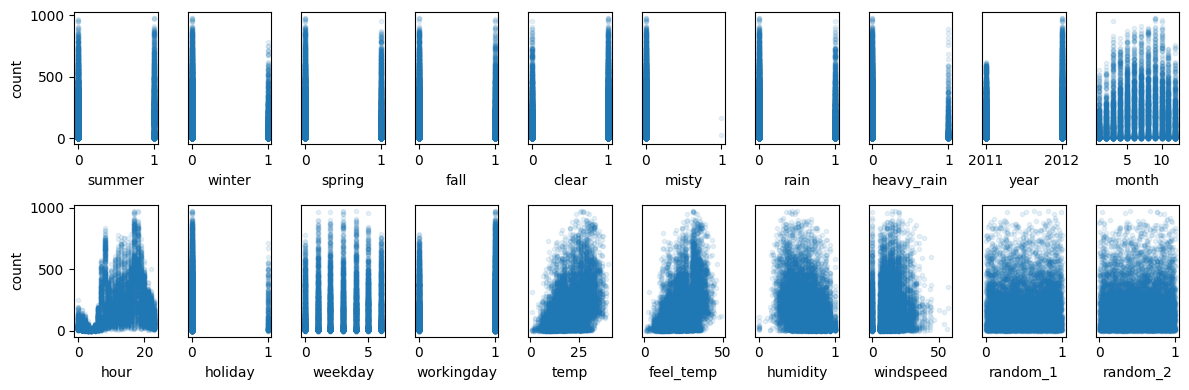

In [4]:
# Get bike sharing data from OpenML
bikes = fetch_openml(data_id=42713, as_frame=True)
X_bike_cat, y_bike = bikes.data, bikes.target


# Optional: take half of the data to speed up processing
X_bike_cat = X_bike_cat.sample(frac=0.5, random_state=1)
y_bike = y_bike.sample(frac=0.5, random_state=1)

# One-hot encode the categorical features
encoder = OneHotEncoder(dtype=int)
preprocessor = ColumnTransformer(transformers=[('cat', encoder, [0,7])], remainder='passthrough')
X_bike = preprocessor.fit_transform(X_bike_cat,y)

# Add 2 random features at the end
random_features = np.random.rand(len(X_bike),2)
X_bike = np.append(X_bike,random_features, axis=1)

# Create feature names
bike_names = ['summer','winter', 'spring', 'fall', 'clear', 'misty', 'rain', 'heavy_rain']
bike_names.extend(X_bike_cat.columns[1:7])
bike_names.extend(X_bike_cat.columns[8:])
bike_names.extend(['random_1','random_2'])

fig, axes = plt.subplots(2, 10, figsize=(12, 4))
for i, ax in enumerate(axes.ravel()):
    ax.plot(X_bike[:, i], y_bike[:], '.', alpha=.1)
    ax.set_xlabel("{}".format(bike_names[i]))
    ax.get_yaxis().set_visible(False)
for i in range(2):
    axes[i][0].get_yaxis().set_visible(True)
    axes[i][0].set_ylabel("count")
fig.tight_layout()

In [ ]:
from sklearn.feature_selection import f_regression, SelectPercentile, mutual_info_regression, SelectFromModel, RFE
from sklearn.preprocessing import scale
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from tqdm.notebook import trange, tqdm

# Pre-compute all importances on bike sharing dataset
# Scaled feature selection thresholds
thresholds = [0.25, 0.5, 0.75, 1]
# Dict to store all data
fs = {}
methods = ['FTest','MutualInformation','RandomForest','Ridge','Lasso','RFE',
           'ForwardSelection','FloatingForwardSelection','Permutation']
for m in methods:
    fs[m] = {}
    fs[m]['select'] = {}
    fs[m]['cv_score'] = {}

def cv_score(selector):
    model = RandomForestRegressor() #RidgeCV() #RandomForestRegressor(n_estimators=100) 
    select_pipe = make_pipeline(StandardScaler(), selector, model)    
    return np.mean(cross_val_score(select_pipe, X_bike, y_bike, cv=3))

# Tuned RF (pre-computed to save time)
# param_grid = {"max_features":[2,4,8,16],"max_depth":[8,16,32,64,128]}
# randomforestCV = GridSearchCV(RandomForestRegressor(n_estimators=200),
#                              param_grid=param_grid).fit(X_bike, y_bike).best_estimator_
randomforestCV = RandomForestRegressor(n_estimators=200,max_features=16,max_depth=128)

# F test
print("Computing F test")
fs['FTest']['label'] = "F test"
fs['FTest']['score'] = f_regression(scale(X_bike),y_bike)[0]
fs['FTest']['scaled_score'] = fs['FTest']['score'] / np.max(fs['FTest']['score'])
for t in tqdm(thresholds):
    selector = SelectPercentile(score_func=f_regression, percentile=t*100).fit(scale(X_bike), y_bike)
    fs['FTest']['select'][t] = selector.get_support()
    fs['FTest']['cv_score'][t] = cv_score(selector)

# Mutual information
print("Computing Mutual information")
fs['MutualInformation']['label'] = "Mutual Information"
fs['MutualInformation']['score'] = mutual_info_regression(scale(X_bike),y_bike,discrete_features=range(13)) # first 13 features are discrete
fs['MutualInformation']['scaled_score'] = fs['MutualInformation']['score'] / np.max(fs['MutualInformation']['score'])
for t in tqdm(thresholds):
    selector = SelectPercentile(score_func=mutual_info_regression, percentile=t*100).fit(scale(X_bike), y_bike)
    fs['MutualInformation']['select'][t] = selector.get_support()
    fs['MutualInformation']['cv_score'][t] = cv_score(selector)
    
# Random Forest
print("Computing Random Forest")
fs['RandomForest']['label'] = "Random Forest"
fs['RandomForest']['score'] = randomforestCV.fit(X_bike, y_bike).feature_importances_
fs['RandomForest']['scaled_score'] = fs['RandomForest']['score'] / np.max(fs['RandomForest']['score'])
for t in tqdm(thresholds):
    selector = SelectFromModel(randomforestCV, threshold="{}*mean".format((1-t))).fit(X_bike, y_bike) # Threshold can't be easily scaled here
    fs['RandomForest']['select'][t] = selector.get_support()
    fs['RandomForest']['cv_score'][t] = cv_score(selector)
    
# Ridge, Lasso
for m in [RidgeCV(),LassoCV()]:
    name = m.__class__.__name__.replace('CV','')
    print("Computing", name)
    fs[name]['label'] = name
    fs[name]['score'] = m.fit(X_bike, y_bike).coef_
    fs[name]['scaled_score'] = np.abs(fs[name]['score']) / np.max(np.abs(fs[name]['score'])) # Use absolute values
    for t in tqdm(thresholds):
        selector = SelectFromModel(m, threshold="{}*mean".format((1-t)*2)).fit(scale(X_bike), y_bike)
        fs[name]['select'][t] = selector.get_support()
        fs[name]['cv_score'][t] = cv_score(selector)
        
# Recursive Feature Elimination
print("Computing RFE")
fs['RFE']['label'] = "Recursive Feature Elimination (with RandomForest)"
fs['RFE']['score'] = RFE(RandomForestRegressor(), n_features_to_select=1).fit(X_bike, y_bike).ranking_
fs['RFE']['scaled_score'] = (20 - fs['RFE']['score'])/ 19
for t in tqdm(thresholds):
    selector = RFE(RandomForestRegressor(), n_features_to_select=int(t*20)).fit(X_bike, y_bike)
    fs['RFE']['select'][t] = selector.support_
    fs['RFE']['cv_score'][t] = cv_score(selector)

# Sequential Feature Selection
print("Computing Forward selection")
for floating in [False]: # Doing only non-floating to speed up computations
    name = "{}ForwardSelection".format("Floating" if floating else "")
    fs[name]['label'] = "{} (with Ridge)".format(name)
    fs[name]['scaled_score'] = np.ones(20) # There is no scoring here
    for t in tqdm(thresholds):
        selector = SequentialFeatureSelector(RidgeCV(), k_features=int(t*20), forward=True, floating=floating).fit(X_bike, y_bike)
        fs[name]['select'][t] = np.array([x in selector.k_feature_idx_ for x in range(20)])
        fs[name]['cv_score'][t] = cv_score(selector)
        
# Permutation Importance  
print("Computing Permutation importance")
fs['Permutation']['label'] = "Permutation importance (with RandomForest))"
fs['Permutation']['score'] = permutation_importance(RandomForestRegressor().fit(X_bike, y_bike), X_bike, y_bike, 
                                                    n_repeats=10, random_state=42, n_jobs=-1).importances_mean
fs['Permutation']['scaled_score'] = fs['Permutation']['score'] / np.max(fs['Permutation']['score'])
sorted_idx = (-fs['Permutation']['score']).argsort() # inverted sort
for t in tqdm(thresholds):
    mask = np.array([x in sorted_idx[:int(t*20)] for x in range(20)])
    fs['Permutation']['select'][t] = mask
    # Hard to use this in a pipeline, resorting to transforming the data beforehand
    fs['Permutation']['cv_score'][t] = np.mean(cross_val_score(RandomForestRegressor(), X_bike[:,mask], y_bike, cv=3))

Computing F test


  0%|          | 0/4 [00:00<?, ?it/s]

Computing Mutual information


  0%|          | 0/4 [00:00<?, ?it/s]

Computing Random Forest


  0%|          | 0/4 [00:00<?, ?it/s]

Computing Ridge


  0%|          | 0/4 [00:00<?, ?it/s]

Computing Lasso


  0%|          | 0/4 [00:00<?, ?it/s]

Computing RFE


  0%|          | 0/4 [00:00<?, ?it/s]

Computing Forward selection


  0%|          | 0/4 [00:00<?, ?it/s]

Computing Permutation importance


  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
def plot_feature_importances(method1='f_test', method2=None, threshold=0.5):
    
    # Plot scores
    x = np.arange(20)
    fig, ax1 = plt.subplots(1, 1, figsize=(12, 3))
    w = 0.3
    imp = fs[method1]
    mask = imp['select'][threshold]
    m1 = ax1.bar(x[mask], imp['scaled_score'][mask], width=w, color='b', align='center')
    ax1.bar(x[~mask], imp['scaled_score'][~mask], width=w, color='b', align='center', alpha=0.3)
    if method2:
        imp2 = fs[method2]
        mask2 = imp2['select'][threshold]
        ax2 = ax1.twinx()
        m2 = ax2.bar(x[mask2] + w, imp2['scaled_score'][mask2], width=w,color='g',align='center')
        ax2.bar(x[~mask2] + w, imp2['scaled_score'][~mask2], width=w,color='g',align='center', alpha=0.3)
        plt.legend([m1, m2],['{} (Ridge R2:{:.2f})'.format(imp['label'],imp['cv_score'][threshold]),
                             '{} (Ridge R2:{:.2f})'.format(imp2['label'],imp2['cv_score'][threshold])], loc='upper left')
    else:
        plt.legend([m1],['{} (Ridge R2:{:.2f})'.format(imp['label'],imp['cv_score'][threshold])], loc='upper left')
    ax1.set_xticks(range(len(bike_names)))
    ax1.set_xticklabels(bike_names, rotation=45, ha="right");
    plt.title("Feature importance (selection threshold {:.2f})".format(threshold))
                        
    plt.show()

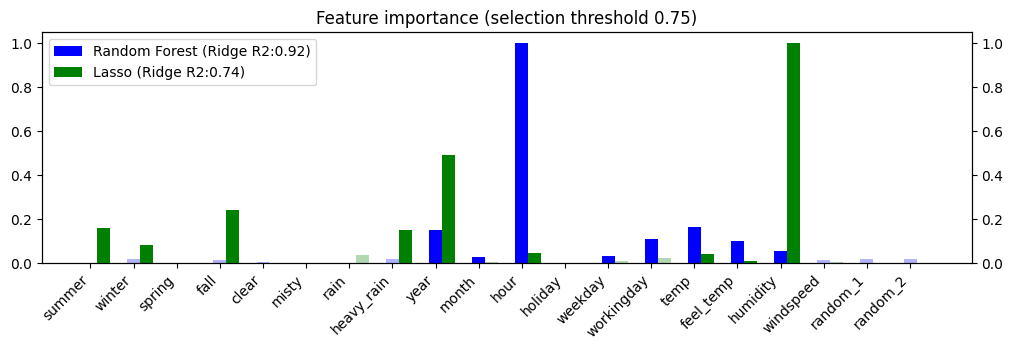

In [11]:
plot_feature_importances('RandomForest', 'Lasso', threshold=0.75)

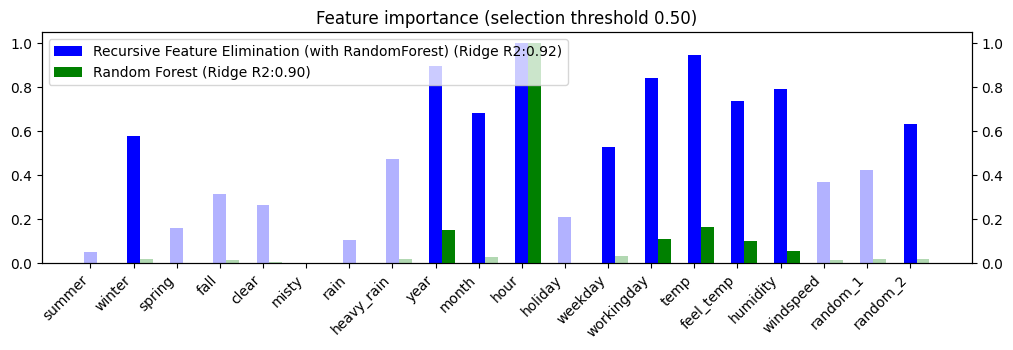

In [12]:
plot_feature_importances('RFE', 'RandomForest', threshold=0.5)

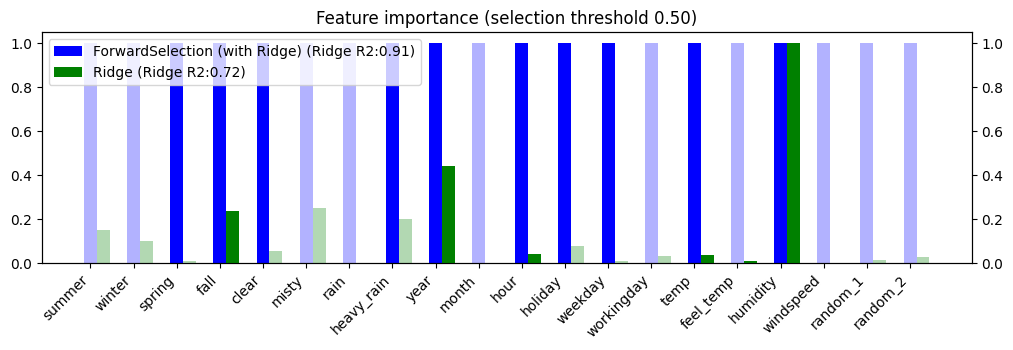

In [13]:
plot_feature_importances('ForwardSelection', 'Ridge', threshold=0.5)

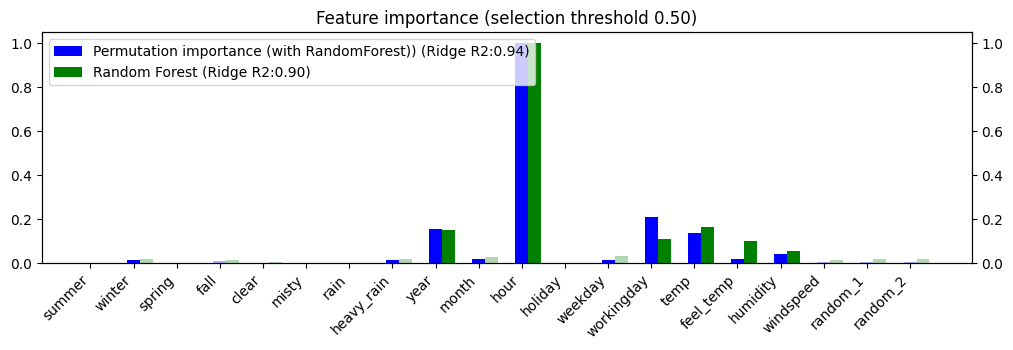

In [14]:
plot_feature_importances('Permutation', 'RandomForest', threshold=0.5)

### 7. Missing value imputation

- Data can be missing in different ways:

    - **Missing Completely at Random (MCAR):** purely random points are missing

    - **Missing at Random (MAR):** 指的是缺失值的发生与观测到的其他变量有关, 但与缺失的值本身无关. 例子: 如果在一项调查中, 收入较高的人更可能不回答收入问题, 这种缺失就可能是随机缺失(MAR). 虽然缺失的是收入的值, 但缺失的模式可以通过其他特征(如教育水平、年龄等)来理解. 

    - **Missing Not At Random (MNAR):** 指的是缺失值的发生与缺失的值本身相关. 这意味着缺失的数据并不是随机, 而是系统性地与其自身的特征有关. 例子: 比如在一项健康研究中, 重病患者可能更倾向于退出研究, 因此他们的健康数据会缺失. 在这种情况下, 缺失的数据与患者的健康状况直接相关.


- Missingness can be encoded in different ways:’?’, ‘-1’, ‘unknown’, ‘NA’,…

- Also labels can be missing (remove example or use semi-supervised learning)


#### 7.1. Mean/constant imputation

用特征的均值或常数值替换缺失值
<p>

缺点:
- 可能导致方差减小, 影响模型性能
- 无法捕捉特征之间的关系

#### 7.2. kNN-based imputation

根据缺失样本的k个最近邻的已知值进行填补
<p>

缺点:
- 计算开销较大, 尤其是数据集较大时。
- 对k值的选择敏感

#### 7.3. Iterative (model-based) imputation

使用回归模型(如随机森林或贝叶斯回归)迭代填补缺失值

工作流程:
- **初始化:** 首先, 用简单的填补方法(如均值填补)填充缺失值, 以初始化数据集.

- **迭代过程:**

    - 对于每个特征列, 使用其他特征作为自变量, 建立回归模型
    - 利用该模型预测当前特征的缺失值
    - 用预测值替代缺失值
    - 重复上述步骤, 直到预测值不再发生显著变化(收敛)
- **收敛条件:** 通常设定一个阈值, 当填补的缺失值变化小于该阈值时, 认为算法收敛. 

#### 7.4. Matrix Factorization techniques

* Basic idea: low-rank approximation
    * Replace missing values by 0
    * Factorize $\mathbf{X}$ with rank $r$: $\mathbf{X}^{n\times p}=\mathbf{U}^{n\times r} \mathbf{V}^{r\times p}$
        * With n data points and p features
        * Solved using gradient descent
    * Recompute $\mathbf{X}$: now complete

**Soft-thresholded Singular Value Decomposition (SVD)**
- Replace missing values by 0, compute SVD: $\mathbf{X}=\mathbf{U} \mathbf{\Sigma} \mathbf{V^{T}}$
    - Solved with gradient descent
- Reduce eigenvalues by shrinkage factor: $\lambda_i = s\cdot\lambda_i$
- Recompute $\mathbf{X}$: now complete
- Repeat for $m$ iterations


### 8. Handling imbalanced data

类别不平衡: 主要类别样本远多于少数类别. 这意味着模型在训练时会接收到大量主要类别的数据, 而少数类别的数据相对较少, 导致模型偏向于主要类别.

**Solutions**:
- 添加类别权重: 在损失函数中, 为少数类别分配更高的权重, 帮助模型在训练时更加关注少数类别
- 重新采样数据/生成合成样本/构建集成模型